In [1]:
import sys
sys.path.append("..")

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.datasets
import torch.utils.data
import PIL.Image

from torchvision import transforms

In [3]:
classnames = {
    1: 'aeroplane',
    2: 'bicycle',
    3: 'bird',
    4: 'boat',
    5: 'bottle',
    6: 'bus',
    7: 'car',
    8: 'cat',
    9: 'chair',
    10: 'cow',
    11: 'diningtable',
    12: 'dog',
    13: 'horse',
    14: 'motorbike',
    15: 'person',
    16: 'potted plant',
    17: 'sheep',
    18: 'sofa',
    19: 'train',
    20: 'tv/monitor'
}

In [4]:
CLASS_MAX = np.amax([c for c in classnames.keys()])
CLASS_DOG = 12
UNET_FOV = 256

In [5]:
import torchvision.transforms.functional as F


class Resize_with_pad:
    def __init__(self, w=1024, h=768, interpolation=transforms.InterpolationMode.BILINEAR):
        self.w = w
        self.h = h

    def __call__(self, image):

        w_1, h_1 = image.size
        ratio_f = self.w / self.h
        ratio_1 = w_1 / h_1


        # check if the original and final aspect ratios are the same within a margin
        if round(ratio_1, 2) != round(ratio_f, 2):

            # padding to preserve aspect ratio
            hp = int(w_1/ratio_f - h_1)
            wp = int(ratio_f * h_1 - w_1)
            if hp > 0 and wp < 0:
                hp = hp // 2
                image = F.pad(image, (0, hp, 0, hp), 0, "constant")
                return F.resize(image, [self.h, self.w])

            elif hp < 0 and wp > 0:
                wp = wp // 2
                image = F.pad(image, (wp, 0, wp, 0), 0, "constant")
                return F.resize(image, [self.h, self.w])

        else:
            return F.resize(image, [self.h, self.w])


In [6]:
rwp = Resize_with_pad(256,256)

In [7]:
transform = transforms.Compose([
    Resize_with_pad(256,256),
    transforms.ToTensor(),
])

In [8]:
target_transform = transforms.Compose([
    Resize_with_pad(256,256, interpolation=transforms.InterpolationMode.NEAREST),
    transforms.PILToTensor(),
])

In [9]:
dataroot = "../data/"

In [10]:
import os
download_ds = not os.path.exists(dataroot + '/VOCdevkit/')

In [11]:
ds_train = torchvision.datasets.VOCSegmentation(root=dataroot, year="2012", image_set="train", download=download_ds, transform=transform, target_transform=target_transform)
ds_val = torchvision.datasets.VOCSegmentation(root=dataroot, year="2012", image_set="val", download=download_ds, transform=transform, target_transform=target_transform)

In [12]:
len(ds_train)

1464

In [13]:
#len(ds_val)

In [14]:
img, mask = ds_train[8]

In [15]:
img.shape

torch.Size([3, 256, 256])

In [16]:
img.dtype

torch.float32

In [17]:
mask.shape

torch.Size([1, 256, 256])

In [18]:
mask.dtype

torch.uint8

In [19]:
num_classes = 20

In [20]:
img.shape

torch.Size([3, 256, 256])

In [21]:
mask.shape[-2]

256

In [22]:
torch.std_mean(img)

(tensor(0.2495), tensor(0.3663))

In [23]:
target_mask = torch.zeros((num_classes, mask.shape[-1], mask.shape[-1]))

In [24]:
target_mask[5,:,:] = torch.where(mask == 5, torch.tensor(1), torch.tensor(0))

In [25]:
(mask == 5).count_nonzero()

tensor(1293)

In [26]:
target_mask.count_nonzero()

tensor(1293)

In [27]:
target_mask[5,:,:].count_nonzero()

tensor(1293)

In [28]:
target_mask = torch.zeros((num_classes, mask.shape[-1], mask.shape[-1]))
one_t, zero_t = torch.tensor(1), torch.tensor(0)
for k in range(num_classes):
    target_mask[k,:,:] = torch.where(mask == k, one_t, zero_t)

In [29]:
target_mask.shape

torch.Size([20, 256, 256])

In [30]:
target_mask = torch.zeros((num_classes, mask.shape[-2], mask.shape[-1]), dtype=torch.float32)

In [31]:
mask.unique()

tensor([  0,   5,  11, 255], dtype=torch.uint8)

In [32]:
# clip all classes above 20 to zero, for example 255 is "border regions and difficult objects"
mask = mask.where(mask < num_classes, torch.zeros(1))

In [33]:
mask.unique()

tensor([ 0.,  5., 11.])

In [34]:
torch.max(mask)

tensor(11.)

In [35]:
target_mask = torch.zeros((num_classes, mask.shape[-2], mask.shape[-1]), dtype=torch.float32)

In [36]:
target_mask.unique()

tensor([0.])

In [37]:
target_mask.shape

torch.Size([20, 256, 256])

In [38]:
torch.tensor([1])

tensor([1])

In [39]:
target_mask.scatter_(0, mask.to(dtype=torch.int64), 1.)

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

In [40]:
target_mask.unique()

tensor([0., 1.])

In [41]:
target_mask.count_nonzero(dim=(1,2))

tensor([45737,     0,     0,     0,     0,  1293,     0,     0,     0,     0,
            0, 18506,     0,     0,     0,     0,     0,     0,     0,     0])

In [42]:
target_mask.shape

torch.Size([20, 256, 256])

In [43]:
mask.unique()

tensor([ 0.,  5., 11.])

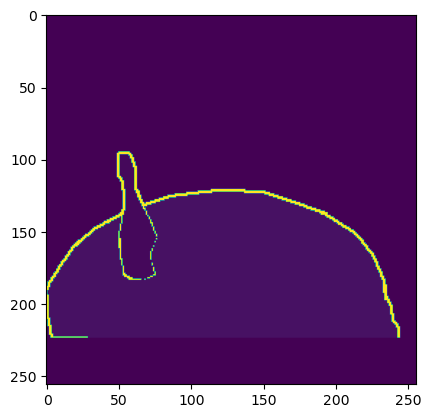

In [44]:
plt.imshow(ds_train[8][1].permute(1, 2, 0).numpy())

In [45]:
ds_train[8][0].dtype

torch.float32

In [46]:
ds_train[8][1].dtype

torch.uint8

In [47]:
img.shape

torch.Size([3, 256, 256])

In [48]:
mask.shape

torch.Size([1, 256, 256])

In [49]:
mask.unique()

tensor([ 0.,  5., 11.])

In [50]:
[classnames[c] for c in mask.unique().tolist() if c in classnames]

['bottle', 'diningtable']

In [51]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=False)

Using cache found in /home/akors/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [52]:
s = ds_train[0][0].unsqueeze(0)

In [53]:
s.shape

torch.Size([1, 3, 256, 256])

In [54]:
out = model.forward(s)

In [55]:
out.shape

torch.Size([1, 1, 256, 256])

In [56]:
mask = ds_train[0][1]

In [57]:
mask.unique()

tensor([  0,   1,  15, 255], dtype=torch.uint8)

In [58]:
mask.count_nonzero()

tensor(2886)

In [59]:
ds_train_dogs_idx = list()
for idx, sample in enumerate(ds_train):
    if sample[1].count_nonzero().item() > 0:
        ds_train_dogs_idx.append(idx)

In [60]:
ds_val_dogs_idx = list()
for idx, sample in enumerate(ds_val):
    if sample[1].count_nonzero().item() > 0:
        ds_val_dogs_idx.append(idx)


In [61]:
len(ds_train_dogs_idx)

1464

In [62]:
ds_train_dogs_idx[1]

1

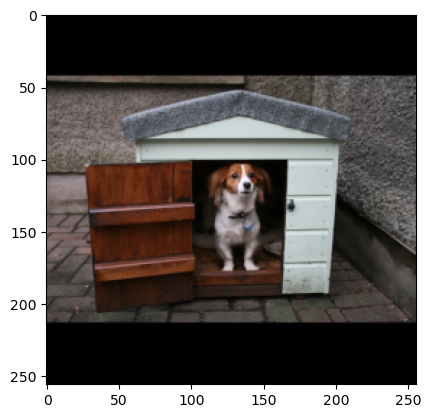

In [63]:
plt.imshow(ds_train[23][0].permute(1, 2, 0).numpy())

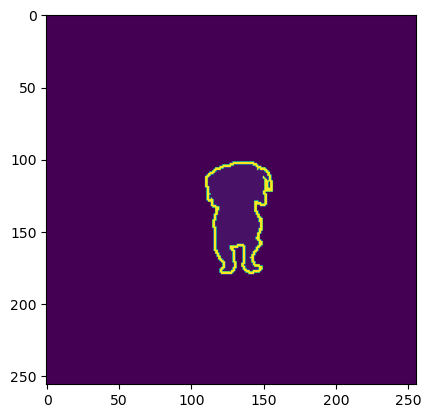

In [64]:
plt.imshow(ds_train[23][1].permute(1, 2, 0).numpy())

In [65]:
ds_train[23][1]

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)

In [66]:
ds_dogs_train = torch.utils.data.Subset(dataset=ds_train, indices=ds_train_dogs_idx)

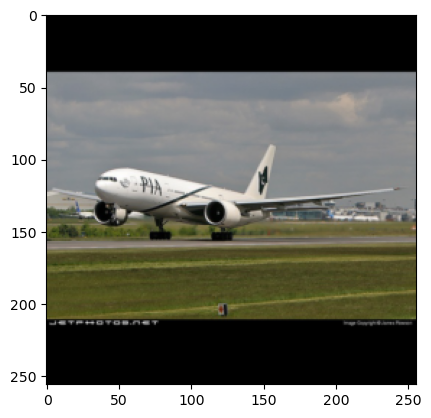

In [67]:
plt.imshow(ds_dogs_train[9][0].permute(1, 2, 0).numpy())

In [68]:
out = model(img.unsqueeze(0))

In [69]:
out.shape

torch.Size([1, 1, 256, 256])

In [70]:
out.dtype

torch.float32

In [71]:
mask.to(device='cuda', dtype=torch.float32)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')

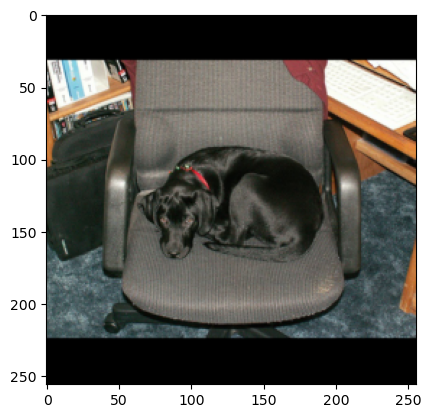

In [72]:
plt.imshow(ds_train[ds_train_dogs_idx[2]][0].permute(1, 2, 0).numpy())